In [1]:
from imports import *

# set columnns display format
pd.set_option('display.max_columns', None)
# default pandas decimal number display format
pd.options.display.float_format = '{:20,.3f}'.format

# Data Acquisition

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def new_zillow_data():
    '''
    This function reads the Zillow data from the mySQL database into a df.
    '''
    # Create SQL query.
    sql_query = '''
    SELECT 
    prop.*,
    pred.logerror,
    pred.transactiondate,
    air.airconditioningdesc,
    arch.architecturalstyledesc,
    build.buildingclassdesc,
    heat.heatingorsystemdesc,
    landuse.propertylandusedesc,
    story.storydesc,
    construct.typeconstructiondesc
FROM
    properties_2017 prop
        INNER JOIN
    (SELECT 
        parcelid, logerror, MAX(transactiondate) AS transactiondate
    FROM
        predictions_2017
    GROUP BY parcelid ,  logerror) pred USING (parcelid)
        LEFT JOIN
    airconditioningtype air USING (airconditioningtypeid)
        LEFT JOIN
    architecturalstyletype arch USING (architecturalstyletypeid)
        LEFT JOIN
    buildingclasstype build USING (buildingclasstypeid)
        LEFT JOIN
    heatingorsystemtype heat USING (heatingorsystemtypeid)
        LEFT JOIN
    propertylandusetype landuse USING (propertylandusetypeid)
        LEFT JOIN
    storytype story USING (storytypeid)
        LEFT JOIN
    typeconstructiontype construct USING (typeconstructiontypeid)
WHERE prop.propertylandusetypeid = 261 AND
        prop.latitude IS NOT NULL
        AND prop.longitude IS NOT NULL
        AND transactiondate <= '2017-12-31';
    '''
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop(columns='id')
    return df

def get_zillow_data():
    '''
    This function reads in zillow data from Zillow database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow_data.csv'):
        
        # If csv file exists, read in data from csv file.
        df = pd.read_csv('zillow_data.csv', index_col=0)
    else:
        
        # Read fresh data from db into a DataFrame.
        df = new_zillow_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('zillow_data.csv')
        
    return df

In [4]:
df = get_zillow_data()

In [5]:
df.shape

(52438, 67)

# Data Preparation

### 1. Missing Values

In [6]:
def handle_missing_values(df, prop_required_columns, prop_required_row):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold) #1, or ‘columns’ : Drop columns which contain missing value
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold) #0, or ‘index’ : Drop rows which contain missing values.
    return df

In [7]:
df = handle_missing_values(df, 0.75, 0.75)

In [8]:
df.shape

(52434, 28)

In [9]:
df = df.dropna()

In [10]:
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
propertylandusedesc             0
dtype: int64

In [10]:
df.shape

(50670, 28)

In [12]:
(52434-50670)/52434

0.03364229316855476

We feel comfortable dropping nulls because it's only 3.4% of the data.

### 2. Rename Columns

In [11]:
df.rename(columns = {'bathroomcnt':'bathrooms', 'bedroomcnt':'bedrooms',
                              'calculatedfinishedsquarefeet':'total_sqft', 'finishedsquarefeet12': 'living_sqft', 'fullbathcnt':'full_bath', 'lotsizesquarefeet':'lot_sqft', 'structuretaxvaluedollarcnt': 'structure_value', 'taxvaluedollarcnt':'assessed_value', 'landtaxvaluedollarcnt':'land_value'}, inplace = True)

In [12]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'calculatedbathnbr', 'total_sqft',
       'living_sqft', 'fips', 'full_bath', 'latitude', 'longitude', 'lot_sqft',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structure_value',
       'assessed_value', 'assessmentyear', 'land_value', 'taxamount',
       'censustractandblock', 'logerror', 'transactiondate',
       'propertylandusedesc'],
      dtype='object')

### 3. Data Mapping, Dummy Variables

In [13]:
df['age'] = 2017 - df['yearbuilt']

In [14]:
df['county'] = df.fips.map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

In [15]:
dummy_df = pd.get_dummies(df[['county']], dummy_na=False, drop_first=False)
df = pd.concat([df, dummy_df], axis=1)

In [16]:
df['taxrate'] = df.taxamount/df.assessed_value*100

In [17]:
df['transaction_month'] = df['transactiondate'].str.slice(5, 7)

### 4. Impute Latitude & Longitude

In [18]:
df.latitude = df.latitude/1000000

In [19]:
df.longitude = df.longitude/1000000

### 5. Drop Unuseful Columns

In [20]:
col = ['regionidzip','assessmentyear','yearbuilt','fips','propertycountylandusecode', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcounty', 'propertylandusedesc', 'transactiondate']
df.drop(columns = col, inplace = True)

### 6. Join Table to get zip code

In [21]:
df.shape

(50670, 25)

In [23]:
geo = pd.read_csv('address.csv')

In [24]:
df = pd.merge(df, geo, on='parcelid', how='inner')

In [25]:
df.head()

,parcelid,bathrooms,bedrooms,calculatedbathnbr,total_sqft,living_sqft,full_bath,latitude,longitude,lot_sqft,regionidcity,roomcnt,structure_value,assessed_value,land_value,taxamount,censustractandblock,logerror,age,county,county_Los Angeles,county_Orange,county_Ventura,taxrate,transaction_month,zip_code
0,14297519,3.500,4.000,3.500,"3,100.000","3,100.000",3.000,33.635,-117.869,"4,506.000","53,571.000",0.000,"485,713.000","1,023,282.000","537,569.000","11,013.720","60,590,630,072,012.000",0.026,19.000,Orange,0,1,0,1.076,01,"92,660.000"
1,17052889,1.000,2.000,1.000,"1,465.000","1,465.000",1.000,34.449,-119.282,"12,647.000","13,091.000",5.000,"88,000.000","464,000.000","376,000.000","5,672.480","61,110,010,023,006.000",0.056,50.000,Ventura,0,0,1,1.223,01,"93,023.000"
2,14186244,2.000,3.000,2.000,"1,243.000","1,243.000",2.000,33.886,-117.823,"8,432.000","21,412.000",6.000,"85,289.000","564,778.000","479,489.000","6,488.300","60,590,218,022,012.000",0.005,55.000,Orange,0,1,0,1.149,01,"92,886.000"
3,12177905,3.000,4.000,3.000,"2,376.000","2,376.000",3.000,34.245,-118.241,"13,038.000","396,551.000",0.000,"108,918.000","145,143.000","36,225.000","1,777.510","60,373,001,001,006.000",-0.103,47.000,Los Angeles,1,0,0,1.225,01,"91,214.000"
4,12095076,3.000,4.000,3.000,"2,962.000","2,962.000",3.000,34.145,-118.180,"63,000.000","47,019.000",0.000,"276,684.000","773,303.000","496,619.000","9,516.260","60,374,608,001,014.000",-0.001,67.000,Los Angeles,1,0,0,1.231,01,"91,105.000"


In [28]:
df = df.dropna()

### 7. Data Types

In [26]:
df.dtypes

parcelid                 int64
bathrooms              float64
bedrooms               float64
calculatedbathnbr      float64
total_sqft             float64
living_sqft            float64
full_bath              float64
latitude               float64
longitude              float64
lot_sqft               float64
regionidcity           float64
roomcnt                float64
structure_value        float64
assessed_value         float64
land_value             float64
taxamount              float64
censustractandblock    float64
logerror               float64
age                    float64
county                  object
county_Los Angeles       uint8
county_Orange            uint8
county_Ventura           uint8
taxrate                float64
transaction_month       object
zip_code               float64
dtype: object

In [29]:
df['zip_code'] = df['zip_code'].astype(int)

In [30]:
df['age'] = df['age'].astype(int)

In [31]:
df['transaction_month']=df['transaction_month'].astype(int)

### 8. Outliers

#### Distribution of `bathroomcnt`, `bedroomcnt`, `calculatedbathnbr`, `calculatedfinishedsquarefeet`, `fullbathcnt`

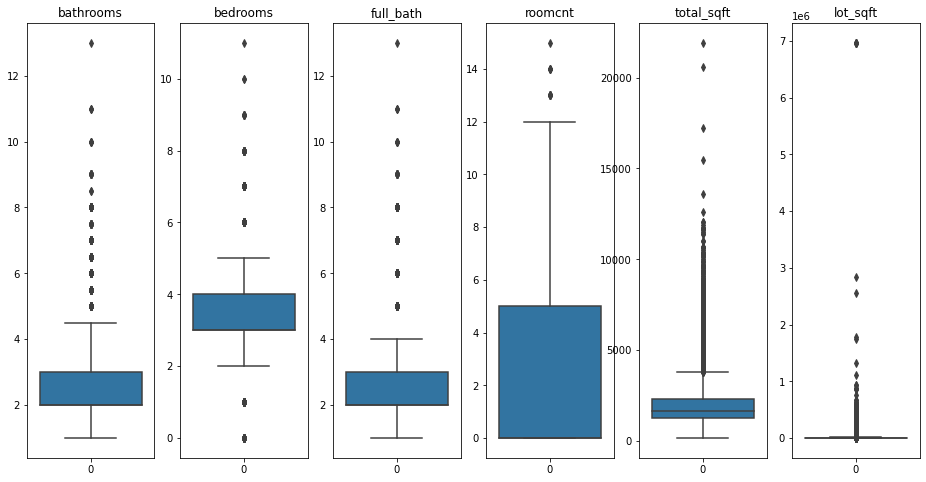

In [54]:
plt.figure(figsize = (16,8))

# List of columns
cols = ['bathrooms', 'bedrooms', 'full_bath', 'roomcnt', 'total_sqft', 'lot_sqft']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,6, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    sns.boxplot(data = df[col])

In [34]:
# bedrooms

q1, q3 = df.bedrooms.quantile([.25, 0.75])
iqr = q3 - q1
k = 2
upper_bound= q3 + k * iqr
upper_bound

6.0

In [33]:
# bathrooms

q1, q3 = df.bathrooms.quantile([.25, 0.75])
iqr = q3 - q1
k = 3
upper_bound= q3 + k * iqr
upper_bound

6.0

In [37]:
# total_sqft

q1, q3 = df.total_sqft.quantile([.25, 0.75])
iqr = q3 - q1
k = 3
upper_bound= q3 + k * iqr
upper_bound

5340.0

In [55]:
# lot_sqft

q1, q3 = df.lot_sqft.quantile([.25, 0.75])
iqr = q3 - q1
k = 10
upper_bound= q3 + k * iqr
upper_bound

40487.5

In [59]:
q3+1.5*iqr

13510.625

In [67]:
df[df.lot_sqft>50000].shape

(731, 25)

#### Distribution of `assessed_value`, `structure_value`, `land_value`

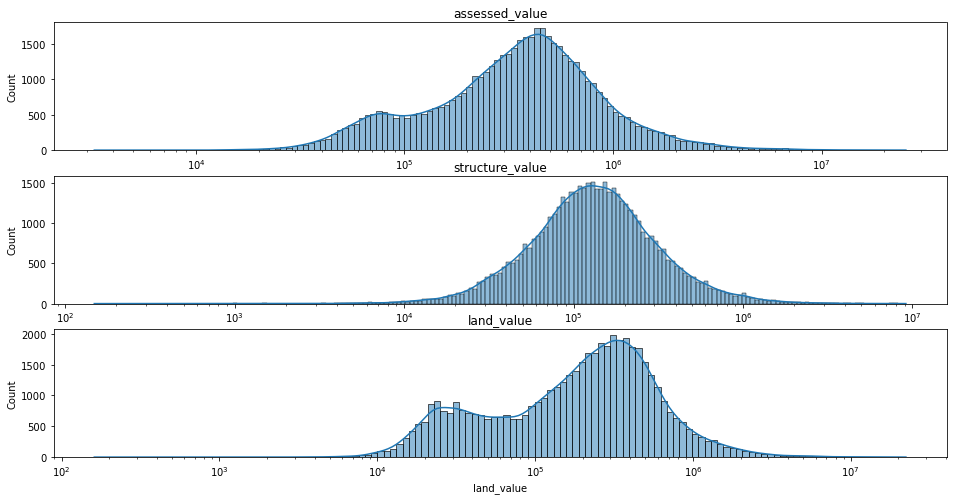

In [40]:
plt.figure(figsize = (16,8))

# List of columns
cols = ['assessed_value', 'structure_value', 'land_value']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(3,1, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    sns.histplot(data=df, x=col, kde=True, log_scale=True)

In [45]:
# assessed_value

q1, q3 = df.assessed_value.quantile([.25, 0.75])
iqr = q3 - q1
k = 1.1
upper_bound= q3 + k * iqr
upper_bound

1071103.6

In [6]:
df = prepare.prep_zillow(df)

### Create bins for zip_code

In [7]:
df.zip_code.value_counts()

93536    684
93535    599
93550    495
93065    458
93551    420
        ... 
92970      1
91204      1
92397      1
93013      1
93563      1
Name: zip_code, Length: 470, dtype: int64

In [7]:
overall_mean = df.logerror.mean()
overall_mean

0.01714059492299396

In [8]:
logerror_zip = df.groupby('zip_code').logerror.mean().reset_index()

In [16]:
logerror_zip

,zip_code,logerror
0,90001,0.004
1,90002,0.007
2,90003,-0.063
3,90004,-0.027
4,90005,0.015
...,...,...
465,93552,0.009
466,93553,-0.008
467,93563,0.146
468,93591,0.047


In [17]:
logerror_zip.to_csv('logeror_zip.csv')

1 -> siginificantly higher
2 -> significantly lower
3 -> insignificantly higher
4 -> insignificantly lower

In [28]:
df.logerror.mean()

0.01714059492299396

In [24]:
for row in range(0,470):
    alpha = 0.05
    sample = df[df.zip_code ==logerror_zip['zip_code'][row]].logerror
    t, p = stats.ttest_1samp(sample, overall_mean)
    if p/2 < alpha:
        print(logerror_zip['zip_code'][row])
        if t>0:
            print('1')
        else:
            print('2')
    if p/2 >= alpha:
        print(logerror_zip['zip_code'][row])
        if t>0:
            print('3')
        else:
            print('4')

90001
4
90002
4
90003
2
90004
2
90005
4
90006
4
90007
4
90008
2
90011
4
90012
4
90013
4
90014
4
90015
4
90016
2
90017
4
90018
4
90019
3
90020
4
90022
3
90023
3
90024
2
90025
4
90026
2
90027
4
90028
4
90029
4
90031
2
90032
4
90033
4
90034
4
90035
4
90036
4
90037
4
90038
2
90039
2
90040
3
90041
2
90042
4
90043
3
90044
4
90045
2
90046
3
90047
4
90048
4
90049
3
90053
2
90056
4
90057
3
90058
3
90059
4
90061
3
90062
2
90063
4
90064
4
90065
4
90066
2
90067
3
90068
3
90069
2
90071
4
90073
4
90077
3
90081
4
90089
4
90094
4
90095
2
90096
4
90201
3
90210
3
90211
4
90212
4
90220
4
90221
4
90222
3
90227
4
90230
4
90232
2
90240
4
90241
3
90242
4
90245
3
90247
4
90248
4
90249
4
90250
4
90254
4
90255
4
90260
3
90261
4
90262
3
90265
1
90266
4
90267
4
90270
3
90272
2
90274
3
90275
3
90277
3
90278
2
90280
4
90290
3
90291
3
90292
3
90293
4
90301
4
90302
2
90303
4
90304
1
90305
2
90306
4
90363
2
90401
3
90402
4
90403
4
90404
3
90405
2
90501
4
90502
3
90503
3
90504
3
90505
3
90506
4
90601
3
90602
4
90603
2


In [50]:
row = 0
while row<=469:
    alpha = 0.05
    sample = df[df.zip_code ==logerror_zip['zip_code'][row]].logerror
    overall_mean = df.logerror.mean()
    
    significantly_high = []
    significantly_low = []
    insignificantly_high = []
    insignificantly_low = []
    
    t, p = stats.ttest_1samp(sample, overall_mean)
    if p/2 < alpha:
        if t>0:
            logerror_zip['cat'][row] == 'siginificantly high'
        else:
            logerror_zip['cat'][row] == 'siginificantly low'
    if p/2 >= alpha:
        if t>0:
            logerror_zip['cat'][row] == 'insiginificantly high'
        else:
            logerror_zip['cat'][row] == 'insiginificantly low'
    else:
        logerror_zip['cat'][row] == 'none'
    row+=1

KeyError: 'cat'

In [57]:
zip_error = pd.read_csv('logeror_zip.csv')

In [58]:
zip_error

,zip_code,group
0,90001,4
1,90002,4
2,90003,2
3,90004,2
4,90005,4
...,...,...
465,93552,4
466,93553,4
467,93563,1
468,93591,3


In [56]:
df.shape

(45130, 23)

In [59]:
df = pd.merge(df, zip_error, on='zip_code', how='left')

In [61]:
df.head(10)

,parcelid,bathrooms,bedrooms,total_sqft,living_sqft,full_bath,latitude,longitude,lot_sqft,roomcnt,structure_value,assessed_value,land_value,taxamount,logerror,age,taxrate,county,transaction_month,county_Los Angeles,county_Orange,county_Ventura,zip_code,group
0,14297519,3.500,4.000,"3,100.000","3,100.000",3.000,33.635,-117.869,"4,506.000",0.000,"485,713.000","1,023,282.000","537,569.000","11,013.720",0.026,19,1.076,Orange,1,0,1,0,92660,3
1,17052889,1.000,2.000,"1,465.000","1,465.000",1.000,34.449,-119.282,"12,647.000",5.000,"88,000.000","464,000.000","376,000.000","5,672.480",0.056,50,1.223,Ventura,1,0,0,1,93023,3
2,14186244,2.000,3.000,"1,243.000","1,243.000",2.000,33.886,-117.823,"8,432.000",6.000,"85,289.000","564,778.000","479,489.000","6,488.300",0.005,55,1.149,Orange,1,0,1,0,92886,3
3,12177905,3.000,4.000,"2,376.000","2,376.000",3.000,34.245,-118.241,"13,038.000",0.000,"108,918.000","145,143.000","36,225.000","1,777.510",-0.103,47,1.225,Los Angeles,1,1,0,0,91214,4
4,12069064,1.000,2.000,738.000,738.000,1.000,34.149,-118.239,"4,214.000",0.000,"18,890.000","218,552.000","199,662.000","2,366.080",0.102,95,1.083,Los Angeles,1,1,0,0,91206,1
5,12790562,3.000,4.000,"3,039.000","3,039.000",3.000,33.960,-118.007,"20,028.000",0.000,"177,527.000","220,583.000","43,056.000","3,104.190",-0.041,47,1.407,Los Angeles,1,1,0,0,90605,4
6,11104527,3.000,4.000,"2,540.000","2,540.000",3.000,34.435,-118.464,"10,384.000",0.000,"271,715.000","430,108.000","158,393.000","6,103.360",0.006,18,1.419,Los Angeles,1,1,0,0,91351,3
7,13944538,2.500,3.000,"1,340.000","1,340.000",2.000,33.771,-117.983,"1,199.000",6.000,"96,617.000","319,668.000","223,051.000","4,078.080",0.046,37,1.276,Orange,1,0,1,0,92844,4
8,17110996,2.500,3.000,"1,371.000","1,371.000",2.000,34.238,-119.171,"3,445.000",5.000,"99,026.000","198,054.000","99,028.000","2,204.840",0.009,13,1.113,Ventura,1,0,0,1,93036,3
9,14375300,2.000,4.000,"1,677.000","1,677.000",2.000,33.643,-117.707,"5,304.000",8.000,"169,118.000","528,847.000","359,729.000","5,496.440",-0.022,36,1.039,Orange,1,0,1,0,92630,3


### 9. Split Data

In [ ]:
def split(df):
    '''
    This function drops the customer_id column and then splits a dataframe into 
    train, validate, and test in order to explore the data and to create and validate models. 
    It takes in a dataframe and contains an integer for setting a seed for replication. 
    Test is 20% of the original dataset. The remaining 80% of the dataset is 
    divided between valiidate and train, with validate being .30*.80= 24% of 
    the original dataset, and train being .70*.80= 56% of the original dataset. 
    The function returns, train, validate and test dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123)   
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test